<h3>ML Zoomcamp - Midterm Project</h3>
<h1>Analyzing Banking Data to Determine Term Deposit Likelyhood</h1>

<h2>Table of Contents</h2>
<ol>
    <li>About</li>
    <li>Data Prep, EDA and Feature Importance</li>
    <li>Model Selection</li><ul>
        <li>Logistic Regression</li>
        <li>Decision Tree</li>
        <li>Random Forest</li>
        <li>Gradient Boost</li>
    </ul>
</ol>

<h2>1. About</h2>

This analysis uses data from the UC Irvine Machine Learning Repository. As per the datasets README:  
  
*The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed.*
  
The purpose of my analysis is to build a model that can predict the likelyhood a bank customer will make a term deposit, based on bank client data, information about contact with customer, and socio-economic context attributes. The full dataset includes 20 attributes and 41,188 customer instances. The final model will be trained and deployed as a webservice, allowing customer data to be sent as a JSON request and a prediction to be returned. **This solution would provide a way for the bank to analyze future customers when targeting their ad campaigns, thus increasing their relative percentage of customers who make a deposit.**
  
The data used in this analysis can be accessed here: https://archive.ics.uci.edu/ml/datasets/bank+marketing
  
This analysis will use "bank-additional-full.csv" to build the model. The file is included in this repository.
  
Attribute data, as outlined in dataset README:  
  
**bank client data:**  
1 - age (numeric)  
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  
**related with the last contact of the current campaign:**  
8 - contact: contact communication type (categorical: 'cellular','telephone')  
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: last contact duration, in seconds (numeric). *Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*  
**other attributes:**  
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; *999 means client was not previously contacted*)  
14 - previous: number of contacts performed before this campaign and for this client (numeric)  
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  
**social and economic context attributes**  
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17 - cons.price.idx: consumer price index - monthly indicator (numeric)  
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
20 - nr.employed: number of employees - quarterly indicator (numeric)  
  
**output variable**
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')  
  
  
Citation: *[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014*

<h2>2. Data Prep, EDA, and Feature Importance</h2>

In [464]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [237]:
data = "bank-additional-full.csv"

In [238]:
df = pd.read_csv(data, sep=";")

In [239]:
df.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [240]:
# standardize/cleanup column names
df.columns = df.columns.str.replace('.', '_')

In [241]:
# check for missing values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [242]:
# convert target variable column to binary
df.y = (df.y == 'yes').astype(int)
df.y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int32

In [243]:
# check for class imbalance
df.y.value_counts(normalize=True)

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

**INTERPRETATION:**  
There is a large class imbalance in this data. Only about 11% of customers make a term deposit. If we were to tune a model that simply predicted no customers make term deposits, we could expect the model would be accurate 89% of the time.

In [472]:
# 60/20/20 split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [473]:
# build lists to analyze categorical and numerical features separately
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)
numerical.remove('y') # remove our target variable from being evaluated as a numerical variable

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp_var_rate'}>],
       [<Axes: title={'center': 'cons_price_idx'}>,
        <Axes: title={'center': 'cons_conf_idx'}>,
        <Axes: title={'center': 'euribor3m'}>],
       [<Axes: title={'center': 'nr_employed'}>, <Axes: >, <Axes: >]],
      dtype=object)

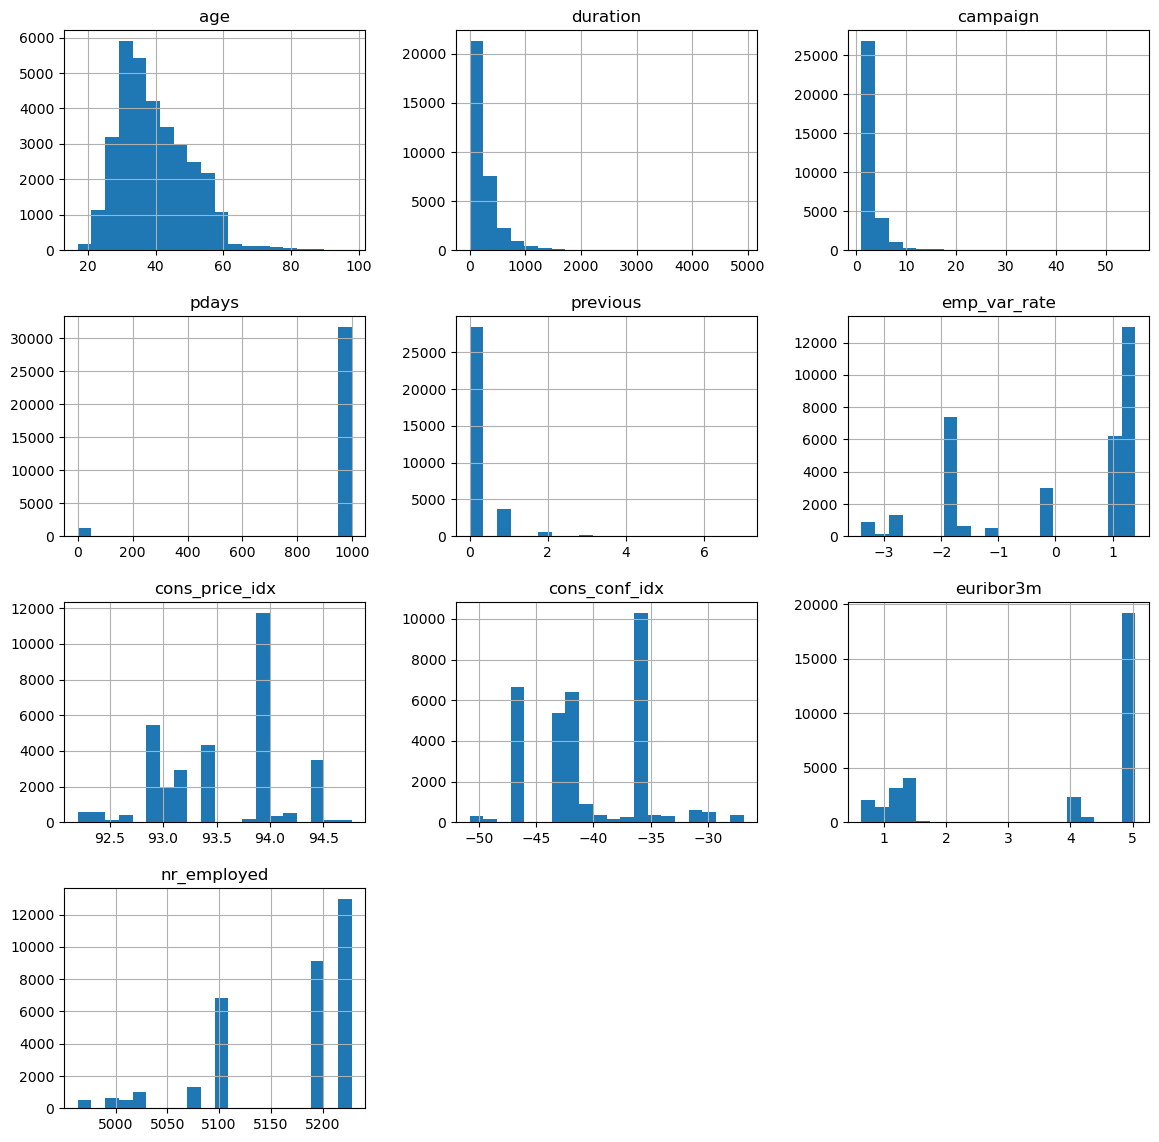

In [246]:
# Let's look at the distribution of our numerical features first
df_full_train[numerical].hist(figsize=(14,14), bins=20)

**INTERPRETATION:**  
Most of these features do not have normal distributions. Let's see where we can improve.

In [247]:
# pdays feature looks odd
print(df_full_train['pdays'])

32694    999
39374    999
13543    999
37649    999
13150    999
        ... 
7813     999
32511    999
5192     999
12172    999
33003    999
Name: pdays, Length: 32950, dtype: int64


**INTERPRETATION:**  
The data explanation includes that while pdays (amount of days since last contact) is a numeric feature, a value of 999 is indicative of no previous contact. This feature may be better suited to a binary variable indicating if the client has been contacted before, but since there is no client identifier in this data we have no way of extrapolating that information. Further analysis is needed to determine if it's better to keep this feature or exclude it.

In [248]:
# Next we'll examine numerical features using correlation
correlation_values = df_full_train[numerical].corrwith(df_full_train['y']).sort_values(ascending=False)

In [249]:
series = pd.Series(correlation_values)
print(series)

duration          0.404063
previous          0.225922
cons_conf_idx     0.059692
age               0.033347
campaign         -0.065664
cons_price_idx   -0.135306
emp_var_rate     -0.295420
euribor3m        -0.304040
pdays            -0.321177
nr_employed      -0.351790
dtype: float64


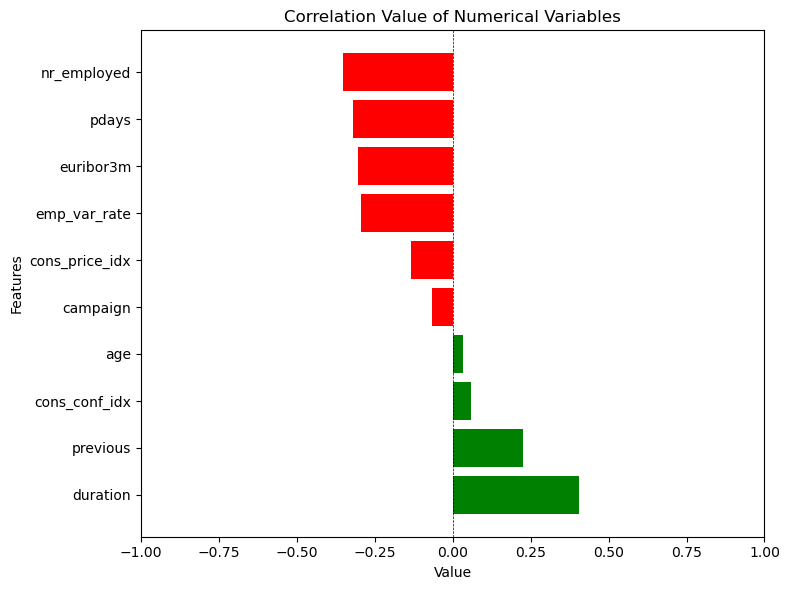

In [250]:
plt.figure(figsize=(8, 6))
plt.barh(series.index, series.values, color=['red' if v < 0 else 'green' for v in series.values])
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)  # Add a vertical line at 0
plt.xlim(-1, 1)  # Set the x-axis range from -1 to 1
plt.xlabel('Value')
plt.ylabel('Features')
plt.title('Correlation Value of Numerical Variables')
plt.tight_layout()
plt.show()

**INTERPRETATION:**  
The highest correlation is found in the duration feature. This presents a problem for training our model, because duration of call is not known before the call is made. We would be unable to feed accurate duration information to make a prediction, as that information would not exist until the outcome of the call was known. Furthermore, our dataset only includes three instances of duration=0 but in all three instances y=0 as well. **This would suggest that a model trained on our dataset would skew towards predicting y=0 on all prediction sets where duration=0.** We may choose to remove this, and rely on other variables within our dataset to train our model, as we would not be able to provide duration in a prediction request.  
Another top correlation was found with pdays. We may want to graph that one to find out more about what is going on.

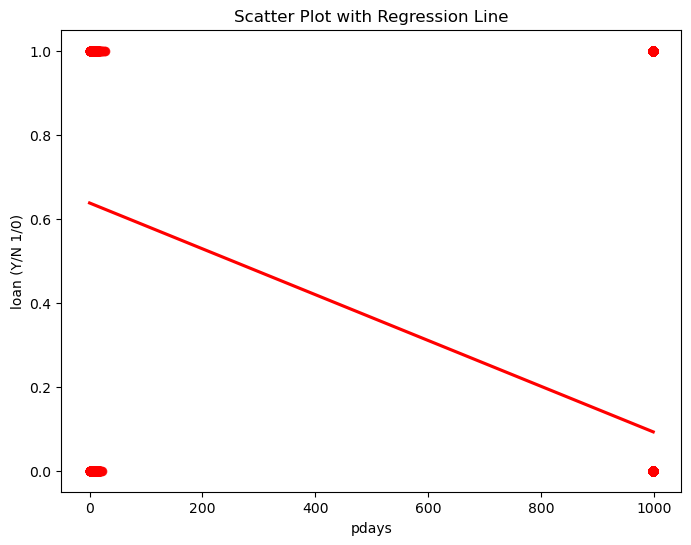

In [474]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_full_train['pdays'], y=df_full_train['y'])

sns.regplot(x=df_full_train['pdays'], y=df_full_train['y'], ci=None, color='red')

# Label axes and add a title
plt.xlabel('pdays')
plt.ylabel('loan (Y/N 1/0)')
plt.title('Scatter Plot with Regression Line')

# Show the plot
plt.show()

**INTERPRETATION:**  
The scatter plot and regression line illustrate why pdays, with a large amount of rows containing '999' to indicate no previous call, is a bad variable. There is a correlation, but it is not a meaningful one. We will not use this feature in our training.

         Category  Frequency
11        unknown        274
10        student        676
9      unemployed        819
8       housemaid        830
7   self-employed       1114
6    entrepreneur       1158
5         retired       1342
4      management       2340
3        services       3180
2      technician       5412
1     blue-collar       7407
0          admin.       8398


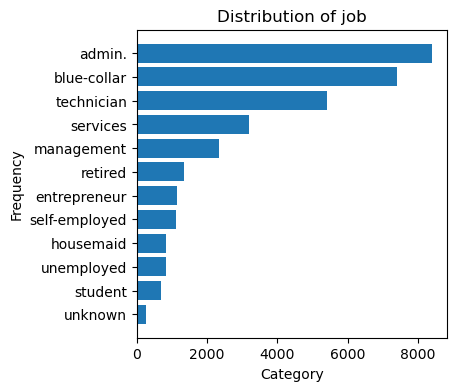

   Category  Frequency
3   unknown         61
2  divorced       3730
1    single       9212
0   married      19947


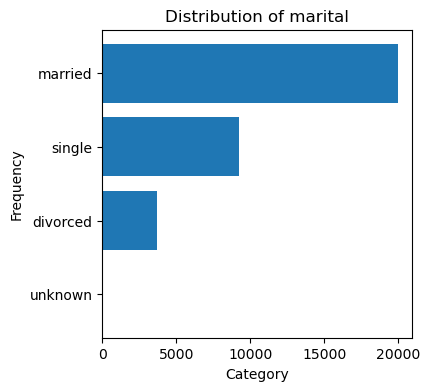

              Category  Frequency
7           illiterate         15
6              unknown       1386
5             basic.6y       1870
4             basic.4y       3340
3  professional.course       4222
2             basic.9y       4775
1          high.school       7629
0    university.degree       9713


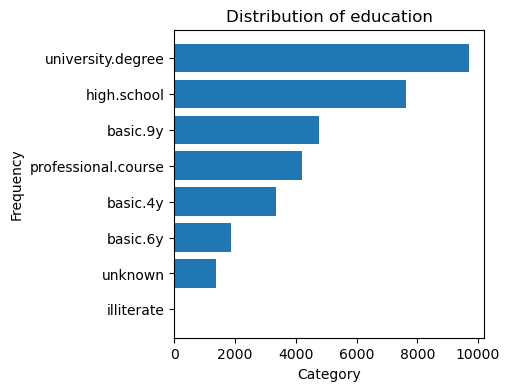

  Category  Frequency
2      yes          3
1  unknown       6830
0       no      26117


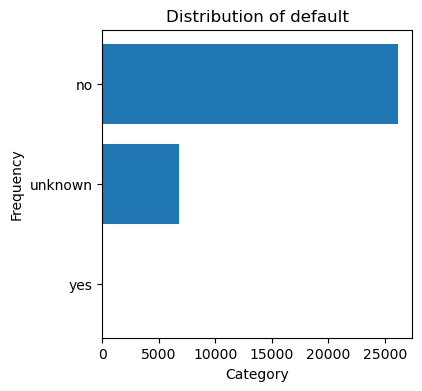

  Category  Frequency
2  unknown        822
1       no      14922
0      yes      17206


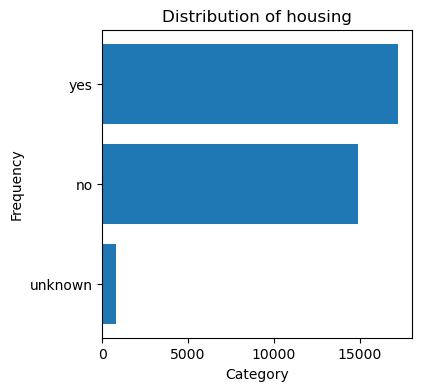

  Category  Frequency
2  unknown        822
1      yes       5043
0       no      27085


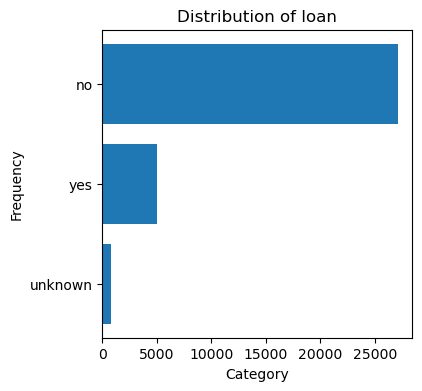

    Category  Frequency
1  telephone      11977
0   cellular      20973


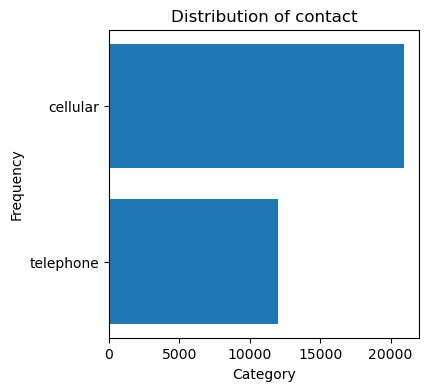

  Category  Frequency
9      dec        151
8      mar        444
7      sep        470
6      oct        568
5      apr       2112
4      nov       3287
3      jun       4226
2      aug       4887
1      jul       5791
0      may      11014


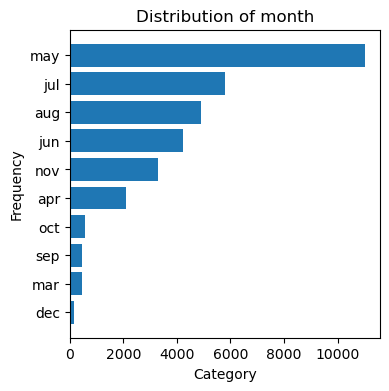

  Category  Frequency
4      fri       6283
3      tue       6465
2      wed       6479
1      mon       6793
0      thu       6930


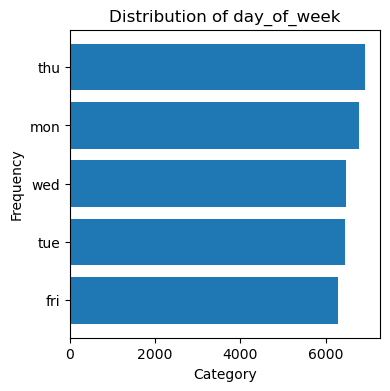

      Category  Frequency
2      success       1087
1      failure       3417
0  nonexistent      28446


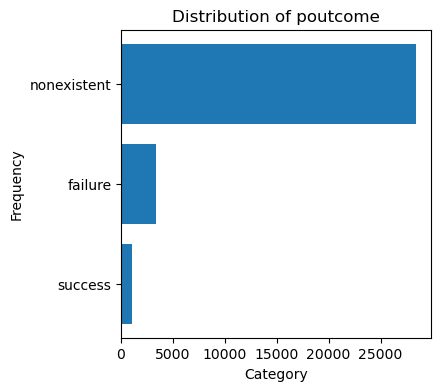

In [252]:
# Next we can use frequency tables to explore our categorical variables
for column in df_full_train[categorical].columns:
    frequency_table = df_full_train[column].value_counts().reset_index()
    frequency_table.columns = ['Category', 'Frequency']

    # Sort the table by category (optional)
    frequency_table = frequency_table.sort_values(by='Frequency')

    # Display the frequency table
    print(frequency_table)

    # Create bar plot for the frequency table
    plt.figure(figsize=(4, 4))
    plt.barh(frequency_table['Category'], frequency_table['Frequency'])
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.show()

In [253]:
# let's look at risk rates across feature responses
global_deposit_rate = df_full_train.y.mean()
global_deposit_rate

0.11216995447647951

In [254]:
risk_rates = []

In [255]:
# we will compare rate at which deposits were made by each group in a category
for c in categorical:
    df_group = df_full_train.groupby(c).y.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_deposit_rate
    df_group['risk'] = df_group['mean'] / global_deposit_rate
    
    # build risk rates list for graphing
    for index, row in df_group.iterrows():
        name = f"{c}:{index}"
        risk = row['risk']
        risk_rates.append((name, risk))
    display(df_group)

,mean,count,diff,risk
job,,,,
admin.,0.129436,8398,0.017266,1.153924
blue-collar,0.069799,7407,-0.042371,0.622260
entrepreneur,0.084629,1158,-0.027541,0.754468
housemaid,0.100000,830,-0.012170,0.891504
management,0.108547,2340,-0.003623,0.967701
retired,0.254844,1342,0.142674,2.271941
self-employed,0.102334,1114,-0.009836,0.912311
services,0.083019,3180,-0.029151,0.740117
student,0.316568,676,0.204398,2.822218


,mean,count,diff,risk
marital,,,,
divorced,0.104558,3730,-0.007612,0.932136
married,0.100015,19947,-0.012155,0.891638
single,0.141229,9212,0.029059,1.259061
unknown,0.163934,61,0.051764,1.461483


,mean,count,diff,risk
education,,,,
basic.4y,0.102994,3340,-0.009176,0.918196
basic.6y,0.075401,1870,-0.036769,0.672204
basic.9y,0.080000,4775,-0.032170,0.713203
high.school,0.108402,7629,-0.003768,0.966410
illiterate,0.200000,15,0.087830,1.783009
professional.course,0.114874,4222,0.002705,1.024111
university.degree,0.135180,9713,0.023010,1.205132
unknown,0.145022,1386,0.032852,1.292874


,mean,count,diff,risk
default,,,,
no,0.127886,26117,0.015716,1.140110
unknown,0.052123,6830,-0.060047,0.464679
yes,0.000000,3,-0.112170,0.000000


,mean,count,diff,risk
housing,,,,
no,0.108028,14922,-0.004142,0.963078
unknown,0.113139,822,0.000969,1.008636
yes,0.115715,17206,0.003545,1.031608


,mean,count,diff,risk
loan,,,,
no,0.112165,27085,-0.000005,0.999959
unknown,0.113139,822,0.000969,1.008636
yes,0.112036,5043,-0.000133,0.998810


,mean,count,diff,risk
contact,,,,
cellular,0.145902,20973,0.033732,1.300722
telephone,0.053102,11977,-0.059068,0.473405


,mean,count,diff,risk
month,,,,
apr,0.198864,2112,0.086694,1.772878
aug,0.106405,4887,-0.005765,0.948603
dec,0.509934,151,0.397764,4.546082
jul,0.091694,5791,-0.020476,0.817456
jun,0.103881,4226,-0.008289,0.926101
mar,0.500000,444,0.387830,4.457522
may,0.063283,11014,-0.048887,0.564172
nov,0.100091,3287,-0.012079,0.892318
oct,0.431338,568,0.319168,3.845397


,mean,count,diff,risk
day_of_week,,,,
fri,0.106319,6283,-0.005851,0.947835
mon,0.100250,6793,-0.011920,0.893735
thu,0.118903,6930,0.006733,1.060028
tue,0.117556,6465,0.005386,1.048017
wed,0.117765,6479,0.005595,1.049881


,mean,count,diff,risk
poutcome,,,,
failure,0.138718,3417,0.026548,1.236679
nonexistent,0.088413,28446,-0.023757,0.788207
success,0.650414,1087,0.538244,5.798469


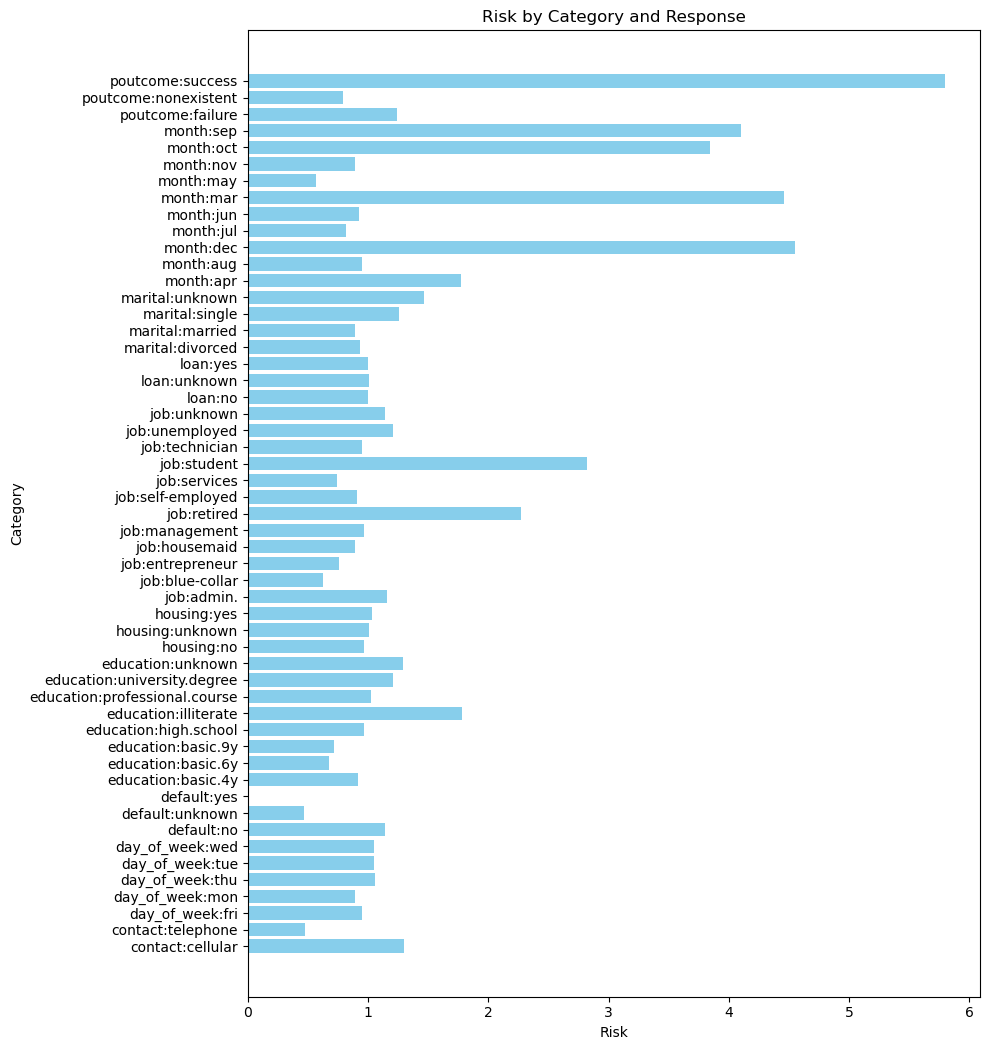

In [256]:
columns = ['category', 'risk']
df_risk_rates = pd.DataFrame(risk_rates, columns=columns)
df_risk_sorted = df_risk_rates.sort_values(by=['category', 'risk'], ascending=[True, True])

plt.figure(figsize=(10, len(df_risk_sorted) * 0.2))
plt.barh(df_risk_sorted['category'], df_risk_sorted['risk'], color='skyblue')
plt.xlabel('Risk')
plt.ylabel('Category')
plt.title('Risk by Category and Response')
plt.tight_layout()
plt.show()

**INTERPRETATION:**  
Since our target variable being positive (customer did deposit) is the desired outcome, we are interpreting "risk" in a positive manner.
According to our analysis, the most influential category and response is poutcome:success, indicating a previously successful advertising campaign would have a very positive effect on future results. After that, certain months of the year look much more successful than others: **this could be caused by the timing of previous advertising campaigns**. Since our dataset does not include information on advertising timing, we would want to make an effort to cross reference this with the client before moving forward.  
The next highest "risk" populations are students, retirees, and illiterate people.  
Notable populations on the lower end include customers contacted by telephone, and blue-collar workers. These populations were far less likely to deposit money on average than the group as a whole.

In [257]:
# analyze categorical features for their mutual information score
def calculate_mutual_info_scores(series):
    return mutual_info_score(series, df_full_train.y).round(5)

In [258]:
mi = df_full_train[categorical].apply(calculate_mutual_info_scores)
mi.sort_values(ascending=False)

poutcome       0.02992
month          0.02671
contact        0.01109
job            0.00967
default        0.00553
education      0.00229
marital        0.00163
day_of_week    0.00029
housing        0.00007
loan           0.00000
dtype: float64

**INTERPRETATION:**  
housing, loan, and day_of_week features give us very little information about a person's likelihood of depositing.
The most information is given by the poutcome feature, followed by month and contact.  
Since we know from our risk assessment that certain months and the poutcome:success variable all carried high likelihood of a deposit, this MI analysis would strengthen the argument for exploring correlation between advertising campaign timing and more successful months of the year.

In [259]:
# remove features to build final categorical/numerical feature lists for model selection
numerical.remove('duration')
numerical.remove('pdays')

categorical, numerical

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'],
 ['age',
  'campaign',
  'previous',
  'emp_var_rate',
  'cons_price_idx',
  'cons_conf_idx',
  'euribor3m',
  'nr_employed'])

In [530]:
# IGNORE: snippet to pull a random customer for testing later
random_customer = df[categorical + numerical].sample(n=1)
random_customer_json = random_customer.to_dict(orient='records')[0]
print(random_customer_json)

{'job': 'admin.', 'marital': 'married', 'education': 'university.degree', 'default': 'no', 'housing': 'no', 'loan': 'yes', 'contact': 'cellular', 'month': 'dec', 'day_of_week': 'tue', 'poutcome': 'success', 'age': 34, 'duration': 196, 'campaign': 2, 'pdays': 6, 'previous': 2, 'emp_var_rate': -3.0, 'cons_price_idx': 92.713, 'cons_conf_idx': -33.0, 'euribor3m': 0.707, 'nr_employed': 5023.5}


In [531]:
random_customer_y = df.loc[random_customer.index]['y']
print(random_customer_y)

39120    1
Name: y, dtype: int32


<h2>5. Model Selection</h2>

In [260]:
# this is our class imbalance, meaning a model that simply predicted 0 in all cases, would be correct ~88.7% of the time.
df.y.value_counts(normalize=True)

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

In [261]:
zero_imbalance = 0.887346

In [262]:
# split our full training set into train/test
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(24712, 8238, 8238)

In [263]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [264]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

<h3>Logistic Regression Model</h3>

In [391]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')
dicts_train = df_train[categorical + numerical].to_dict(orient='records')

In [392]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)
y_full_train = df_full_train.y.values
X_train = dv.fit_transform(dicts_train)
y_train = df_train.y.values

In [267]:
model = LogisticRegression(random_state=1, max_iter=1000)
model.fit(X_full_train, y_full_train)

LogisticRegression(max_iter=1000, random_state=1)

In [268]:
dicts_val = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(dicts_val)

In [269]:
# get predictions
y_pred = model.predict_proba(X_val)[:, 1]
deposit_decision = (y_pred >= 0.5) # we will tune this score later

In [270]:
# calculate actual percentage of correct predictions with this model
log_model_1 = (deposit_decision == y_val).mean()
log_model_1

0.9003398883224083

In [271]:
print(f"Accuracy: {(log_model_1 * 100).round(2)}%")
print(f"Difference: {((log_model_1 - zero_imbalance) * 100).round(2)}%")

Accuracy: 90.03%
Difference: 1.3%


In [272]:
# see if threshold makes a difference
thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('Threshold: %.2f Accuracy: %.2f' % (t, score * 100) + '%')

Threshold: 0.00 Accuracy: 11.39%
Threshold: 0.05 Accuracy: 45.34%
Threshold: 0.10 Accuracy: 79.66%
Threshold: 0.15 Accuracy: 84.62%
Threshold: 0.20 Accuracy: 86.32%
Threshold: 0.25 Accuracy: 87.59%
Threshold: 0.30 Accuracy: 87.95%
Threshold: 0.35 Accuracy: 88.60%
Threshold: 0.40 Accuracy: 89.23%
Threshold: 0.45 Accuracy: 89.73%
Threshold: 0.50 Accuracy: 90.03%
Threshold: 0.55 Accuracy: 89.95%
Threshold: 0.60 Accuracy: 89.68%
Threshold: 0.65 Accuracy: 89.48%
Threshold: 0.70 Accuracy: 89.37%
Threshold: 0.75 Accuracy: 89.18%
Threshold: 0.80 Accuracy: 88.83%
Threshold: 0.85 Accuracy: 88.66%
Threshold: 0.90 Accuracy: 88.61%
Threshold: 0.95 Accuracy: 88.61%
Threshold: 1.00 Accuracy: 88.61%


**INTERPRETATION:**  
Full model is in line with original mean of dataset. Without weighting for class imbalance, our best score is at a threshold of .5, but it's only 1.3% better than just predicting all outcomes to be 0.

In [212]:
# let's try to balance the model to account for the class imbalance
model = LogisticRegression(class_weight='balanced', random_state=1, max_iter=1000)
model.fit(X_full_train, y_full_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1)

In [213]:
y_pred = model.predict_proba(X_val)[:, 1]
deposit_decision = (y_pred >= 0.5)

In [214]:
log_model_2 = (deposit_decision == y_val).mean()
log_model_2

0.805778101480942

In [215]:
print(f"Accuracy: {(log_model_2 * 100).round(2)}%")
print(f"Difference: {((log_model_2 - zero_imbalance) * 100).round(2)}%")

Accuracy: 80.58%
Difference: -8.16%


**INTERPRETATION:**  
Using the 'balanced' class weight option actually yields worse results than without, this model is >8% worse than just predicting all 0. Let's investigate further.

In [216]:
# check threshold influence on weighted model
thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('Threshold: %.2f Accuracy: %.2f' % (t, score * 100) + '%')

Threshold: 0.00 Accuracy: 11.39%
Threshold: 0.05 Accuracy: 11.40%
Threshold: 0.10 Accuracy: 11.59%
Threshold: 0.15 Accuracy: 14.24%
Threshold: 0.20 Accuracy: 27.58%
Threshold: 0.25 Accuracy: 36.23%
Threshold: 0.30 Accuracy: 49.83%
Threshold: 0.35 Accuracy: 64.79%
Threshold: 0.40 Accuracy: 74.11%
Threshold: 0.45 Accuracy: 77.26%
Threshold: 0.50 Accuracy: 80.58%
Threshold: 0.55 Accuracy: 83.67%
Threshold: 0.60 Accuracy: 84.60%
Threshold: 0.65 Accuracy: 85.37%
Threshold: 0.70 Accuracy: 86.71%
Threshold: 0.75 Accuracy: 87.69%
Threshold: 0.80 Accuracy: 87.84%
Threshold: 0.85 Accuracy: 88.88%
Threshold: 0.90 Accuracy: 89.66%
Threshold: 0.95 Accuracy: 88.99%
Threshold: 1.00 Accuracy: 88.61%


**INTERPRETATION:**  
With the model configured to balance classes, our accuracy peaks at a threshold of .9 but still does not outperform a model where class imbalance is not addressed.
We may need a different performance metric, or a different model structure altogether. Let's explore the model a bit more with precision/recall and AUC to see if it looks better with a different metric.

In [217]:
# rebuild model without weighting
model = LogisticRegression(random_state=1, max_iter=1000)
model.fit(X_full_train, y_full_train)

LogisticRegression(max_iter=1000, random_state=1)

In [218]:
y_pred = model.predict_proba(X_val)[:, 1]

In [273]:
# make a confusion table
actual_pos = (y_test == 1) # people who will make a deposit
actual_neg = (y_test == 0) # people who won't make a deposit

t = 0.5
predict_pos = (y_pred >= t)
predict_neg = (y_pred < t)

In [274]:
# true positives
tp = (predict_pos & actual_pos).sum()
# true negatives
tn = (predict_neg & actual_neg).sum()
# false positives
fp = (predict_pos & actual_neg).sum()
# false negatives
fn = (predict_neg & actual_pos).sum()

In [275]:
# precision is the fraction of positive predictions that were correct
# (customers who were predicted to and did make a deposit, out of all customers predicted to make a deposit)
p = tp / (tp + fp)
p

# this model is wrong about 88% of the time when predicting a customer will deposit

0.11815561959654179

In [276]:
# recall is the fraction of correctly identified positive examples
# (customers who were predicted to and did make a deposit, out of all customers that actually did make a deposit)
r = tp / (tp + fn)
r

# the model fails to identify 4% of the customers who actually will make a deposit

0.04343220338983051

In [277]:
# true positive rate: how many correctly identified positives out of all the actual positives
tpr = tp / (tp + fn)
# false positive rate: how many incorrectly identified positives (actual negatives) out of all the actual negatives
fpr = fp / (tn + fp)
print(tpr, fpr)

0.04343220338983051 0.041952289553057305


In [278]:
# iterate over different thresholds to find the optimal one
scores = []

# set up an array of thresholds
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t) # above threshold
    predict_negative = (y_pred < t) # below threshold

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [279]:
# create a dataframe for all threshold rates, and scores
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# calculate columns for true positive rate and false positive rate
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

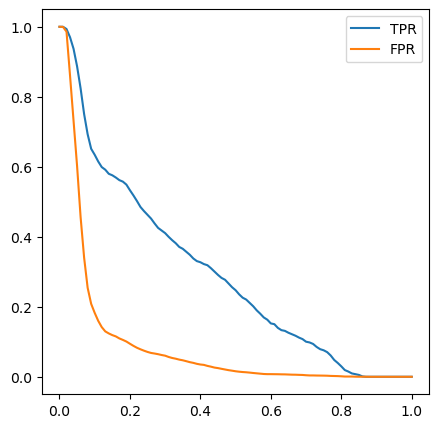

In [280]:
# plot true positive vs false positive rates
plt.figure(figsize=(5,5))
plt.plot(df_scores.threshold, df_scores['tpr'], label="TPR")
plt.plot(df_scores.threshold, df_scores['fpr'], label="FPR")
plt.legend()

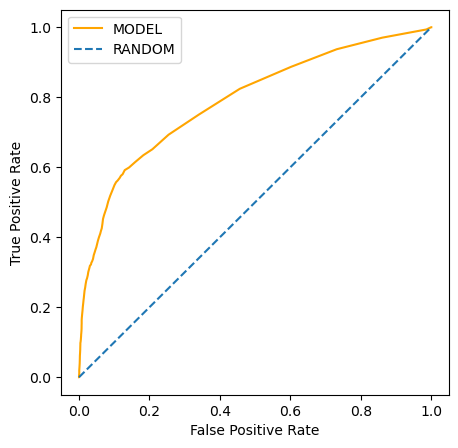

In [281]:
# ROC AUC curve
# plot the false positive rate against true positive rate
# for model and benchmarks
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label="MODEL", color='orange')
#plt.plot(df_rand.fpr, df_rand.tpr, label="RANDOM", color='gray')
plt.plot([0, 1], [0, 1], label="RANDOM", linestyle='--')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label="IDEAL", color='green')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [282]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.789517335046879

In [284]:
roc_auc_score(y_test, y_pred)

0.49898127030343026

**INTERPRETATION:**  
AUC score is .79 for the validation data, but fails on the testing data. .5 is no better than random guessing. 
Let's explore other models to see if we can improve.

<h3>Decision Tree Model</h3>

In [320]:
dt = DecisionTreeClassifier()
dt.fit(X_full_train, y_full_train)

DecisionTreeClassifier()

In [321]:
# validation scores
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9998844086806671

In [322]:
# actual training scores
y_pred = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.6234818901535043

**INTERPRETATION:**  
The decision tree model is better at predicting than the logistic regression model, but it is overfitting. It memorizes the data, but fails to generalize. We will tune this by controlling for depth.

In [323]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_full_train, y_full_train)

DecisionTreeClassifier(max_depth=2)

In [324]:
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

y_pred = dt.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('test:', auc)

val: 0.7347959079358589
test: 0.7492032573789462


In [325]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- nr_employed <= 5087.65
|   |--- poutcome=success <= 0.50
|   |   |--- class: 0
|   |--- poutcome=success >  0.50
|   |   |--- class: 1
|--- nr_employed >  5087.65
|   |--- cons_conf_idx <= -46.65
|   |   |--- class: 0
|   |--- cons_conf_idx >  -46.65
|   |   |--- class: 0



**INTERPRETATION:**  
Here the training and validation scores are closer, and we can see that fewer features actually led to a better real-world result. Now we can train for the optimal depth.

In [326]:
# optimize for depth
depth_scores = []

for d in range(1,50):
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_full_train, y_full_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    v_auc = roc_auc_score(y_val, y_pred)
    
    y_pred = dt.predict_proba(X_test)[:, 1]
    t_auc = roc_auc_score(y_test, y_pred)
    
    depth_scores.append((d, v_auc, t_auc))

df_depth_scores = pd.DataFrame(depth_scores, columns=['d', 'v_auc', 't_auc'])
df_depth_scores.sort_values(by='t_auc', ascending=False).head(10)

,d,v_auc,t_auc
4,5,0.785334,0.792731
5,6,0.790602,0.792498
6,7,0.793734,0.787707
7,8,0.803489,0.782697
3,4,0.763898,0.781568
8,9,0.814441,0.774585
2,3,0.740685,0.756743
9,10,0.826354,0.750120
1,2,0.734796,0.749203
10,11,0.842886,0.729698


**INTERPRETATION:**  
Optimal depth looks like it's around 4-8. Now training for min_samples_leaf:

In [333]:
scores = []

for d in range(4, 15):
    for s in [1, 2, 5, 10, 15, 20, 100, 125, 150, 175, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_full_train, y_full_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

In [334]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
120,14,1,0.901181
121,14,2,0.899270
122,14,5,0.888167
108,13,1,0.884617
109,13,2,0.882602


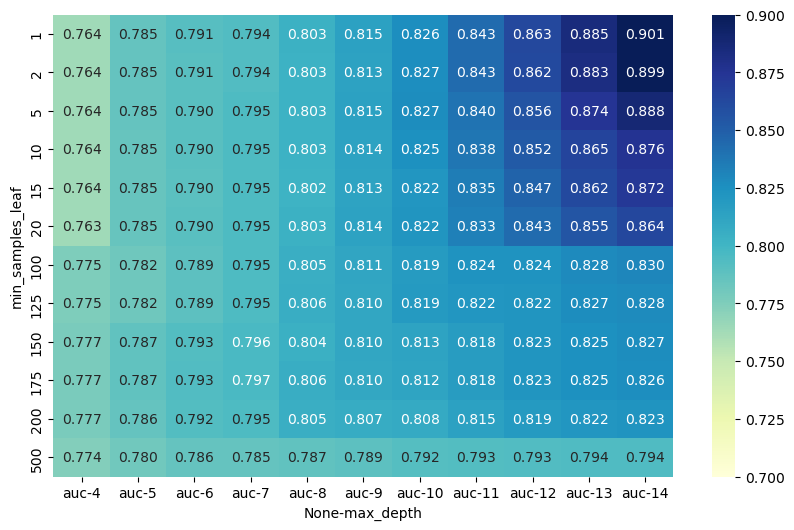

In [335]:
# pivot the data to make it easier to interpret
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
plt.figure(figsize=(10, 6))
sns.heatmap(df_scores_pivot, cmap="YlGnBu", annot=True, fmt='.3f', vmin=0.7, vmax=0.9)
plt.show()

**INTERPRETATION:**  
It would appear that as leaf size decreases and min_sample_size increases, the model gets more accurate, but we know that decision trees have a tendency to overfit. Let's look at the test data to see if that's the case.

In [336]:
# Now try on test data
scores = []

for d in range(4, 15):
    for s in [1, 2, 5, 10, 15, 20, 100, 125, 150, 175, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_full_train, y_full_train)

        y_pred = dt.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        
        scores.append((d, s, auc))

In [337]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
40,7,15,0.799037
52,8,15,0.799012
29,6,20,0.798764
53,8,20,0.798759
39,7,10,0.798742


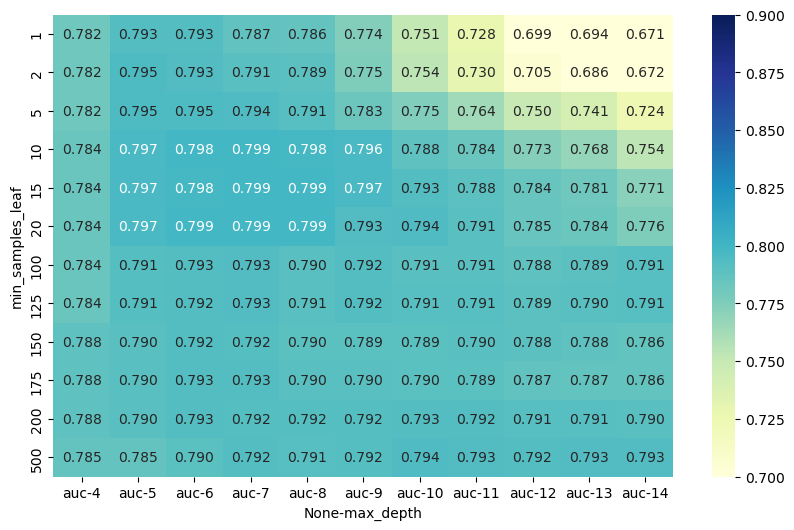

In [340]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
plt.figure(figsize=(10, 6))
sns.heatmap(df_scores_pivot, cmap="YlGnBu", annot=True, fmt='.3f', vmin=0.7, vmax=0.9)
plt.show()

**INTERPRETATION:**  
Our auc score using test data shows the true scoring for the model, we need to choose a min_samples_leaf of 15 and max_depth of 7.

In [344]:
dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=15)
dt.fit(X_full_train, y_full_train)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.794667976166136

In [462]:
dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=15)
dt.fit(X_full_train, y_full_train)

y_pred = dt.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
auc

0.7991589906726216

<h3>7. Random Forest</h3>

In [346]:
rf = RandomForestClassifier(n_estimators=10, random_state=1) # fixed random state for reproducibility
rf.fit(X_full_train, y_full_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [347]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.998410199491778

**INTERPRETATION:**  
The model is overfitting, let's tune the number of estimators.

In [354]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n,
                                random_state=1,
                                n_jobs=-1)
    rf.fit(X_full_train, y_full_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [355]:
columns = ['n_estimators', 'auc']
df_val_scores = pd.DataFrame(scores, columns=columns)

In [356]:
df_val_scores

,n_estimators,auc
0,10,0.998418
1,20,0.999381
2,30,0.999654
3,40,0.999716
4,50,0.999755
5,60,0.999785
6,70,0.999791
7,80,0.999791
8,90,0.999805
9,100,0.999814


**INTERPRETATION:**  
Model seems to be overfitting when trained on full_train data. Let's compare the test validation scores to see if it really is overfitting.

In [358]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n,
                                random_state=1,
                                n_jobs=-1)
    rf.fit(X_full_train, y_full_train)
    
    y_pred = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    scores.append((n, auc))

In [359]:
columns = ['n_estimators', 'auc']
df_test_scores = pd.DataFrame(scores, columns=columns)

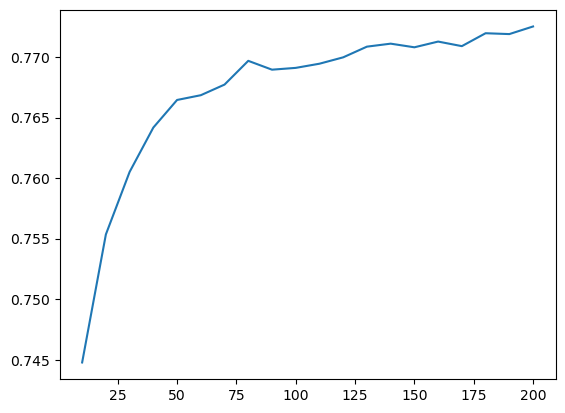

In [361]:
plt.plot(df_test_scores.n_estimators, df_test_scores.auc)

**INTERPRETATION:**  
This type of model does seem to be overfitting the data pretty badly. The roc/auc for this model isn't as good as our decision tree model yet. Let's see if tuning for depth helps at all.

In [366]:
# tune for depth
scores = []

for d in [5, 7, 8, 10, 15]:
    for n in range(150, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_full_train, y_full_train)

        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        scores.append((d, n, auc))

In [367]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

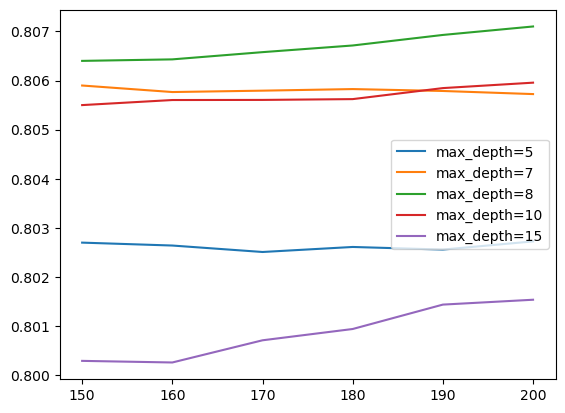

In [368]:
for d in [5, 7, 8, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f'max_depth={d}')
plt.legend()

**INTERPRETATION:**  
We choose max_depth = 8, and tune for best min_samples_leaf

In [369]:
max_depth = 8

In [376]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_full_train, y_full_train)

        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        scores.append((s, n, auc))

In [377]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [378]:
colors = ['black', 'blue', 'red', 'orange', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
list(zip(min_samples_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'red'), (10, 'orange'), (50, 'grey')]

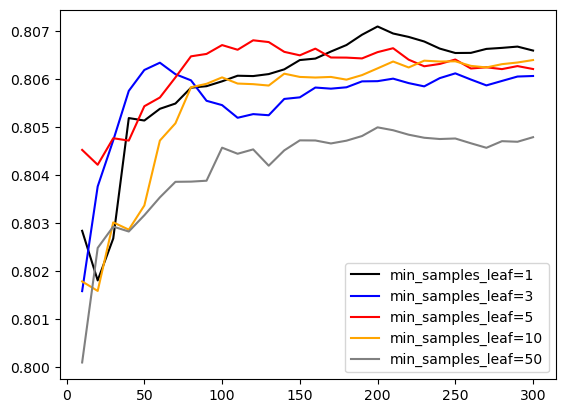

In [379]:
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, 
             df_subset.auc, 
             color=col,
             label=f'min_samples_leaf={s}')

plt.legend()

**INTERPRETATION:**  
min_samples_leaf = 1 performs best, with 200 n_estimators.

**INTERPRETATION:**  
Here are the final tuned parameters for our Random Forest model:

In [382]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=1,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
auc

0.8071003477434435

<h3>8. Gradient Boost</h3>

In [393]:
# train a gradient boost model to see if we can improve any further
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [394]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [395]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [396]:
s = output.stdout
print(s)

[0]	train-auc:0.79563	val-auc:0.78394
[5]	train-auc:0.81690	val-auc:0.79276
[10]	train-auc:0.84106	val-auc:0.80442
[15]	train-auc:0.85235	val-auc:0.80301
[20]	train-auc:0.86260	val-auc:0.79976
[25]	train-auc:0.87203	val-auc:0.79707
[30]	train-auc:0.87589	val-auc:0.79610
[35]	train-auc:0.88056	val-auc:0.79614
[40]	train-auc:0.88443	val-auc:0.79521
[45]	train-auc:0.88812	val-auc:0.79514
[50]	train-auc:0.89485	val-auc:0.79209
[55]	train-auc:0.90031	val-auc:0.79071
[60]	train-auc:0.90391	val-auc:0.78957
[65]	train-auc:0.90742	val-auc:0.78916
[70]	train-auc:0.91006	val-auc:0.78782
[75]	train-auc:0.91314	val-auc:0.78622
[80]	train-auc:0.91570	val-auc:0.78437
[85]	train-auc:0.91964	val-auc:0.78291
[90]	train-auc:0.92207	val-auc:0.78224
[95]	train-auc:0.92411	val-auc:0.78155
[100]	train-auc:0.92623	val-auc:0.78158
[105]	train-auc:0.93051	val-auc:0.78118
[110]	train-auc:0.93338	val-auc:0.77944
[115]	train-auc:0.93492	val-auc:0.77921
[120]	train-auc:0.93809	val-auc:0.77780
[125]	train-auc:0.9419

**INTERPRETATION:**  
We could parse this output and bring it into a plot, but it's pretty easy to see validation score peaks around 15 then never rises again. Meanwhile our training data never reaches 1, even in 200 rounds.  
Let's train for ETA.

In [397]:
# function to help us plot xgb scores
def parse_xgb_output(output):
    results = []
    tree = []
    aucs_train = []
    aucs_val = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [398]:
# scores dictionary to hold all our xgb values and eta while we tune
scores = {}

In [409]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # specify the evaluation metric you want to see
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  verbose_eval=5, 
                  evals=watchlist)

In [410]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [411]:
scores.keys()

dict_keys(['eta=1.0', 'eta=0.1', 'eta=0.3', 'eta=0.01'])

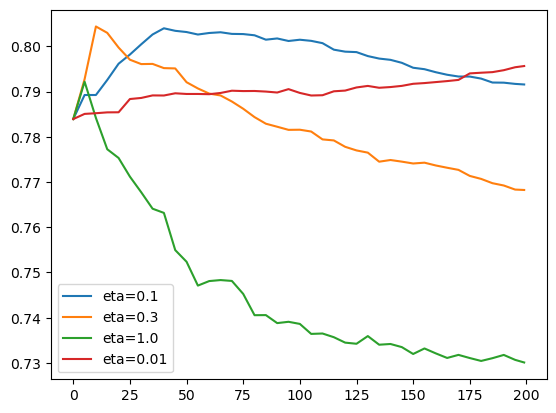

In [412]:
# plot the results
etas = ['eta=0.1', 'eta=0.3', 'eta=1.0', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

**INTERPRETATION:**  
Our best ETA looks like 0.3, with a sharp peak at around 20, let's tune max_depth.

In [417]:
eta = 0.3

In [418]:
# tune for max_depth
scores = {}

In [437]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # specify the evaluation metric you want to see
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  verbose_eval=5, 
                  evals=watchlist)

In [438]:
key = 'depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [439]:
scores.keys()

dict_keys(['depth=1', 'depth=2', 'depth=3', 'depth=4', 'depth=5', 'depth=10', 'depth=20'])

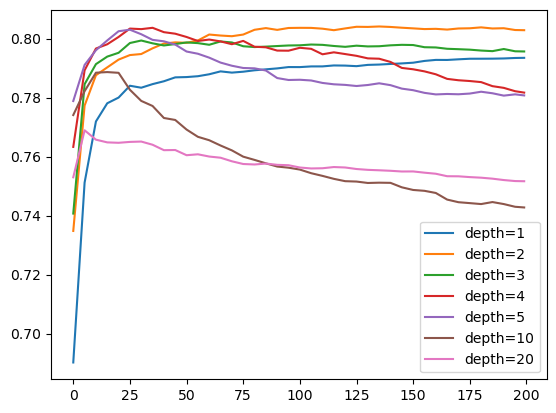

In [440]:
# plot the results
depths = ['depth=1', 'depth=2', 'depth=3', 'depth=4', 'depth=5', 'depth=10', 'depth=20']

for depth in depths:
    df_score = scores[depth]
    plt.plot(df_score.num_iter, df_score.val_auc, label=depth)
plt.legend()

**INTERPRETATION:**  
Depth of 2 is best, next we tune min_child_weight

In [441]:
# tune for min_child_weight
scores = {}

In [455]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 2,
    'min_child_weight': 100,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # specify the evaluation metric you want to see
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  verbose_eval=5, 
                  evals=watchlist)

In [456]:
key = 'weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

In [457]:
scores.keys()

dict_keys(['weight=1', 'weight=2', 'weight=3', 'weight=15', 'weight=100'])

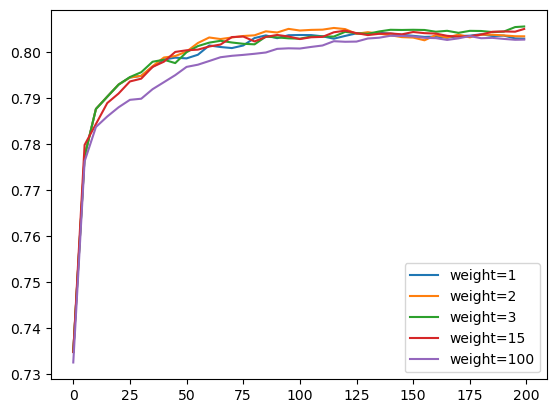

In [458]:
# plot the results
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()

In [459]:
# FINAL XGBOOST MODEL
xgb_params = {
    'eta': 0.3,
    'max_depth': 2,
    'min_child_weight': 2,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [460]:
y_pred = model.predict(dval)

In [461]:
roc_auc_score(y_val, y_pred)

0.8042938925723633

<h3>Final Model Selection</h3>
Best model was the Random Forest model, achieving a AUC of 0.807

In [468]:
model = RandomForestClassifier(n_estimators=200,
                            max_depth=2,
                            min_samples_leaf=1,
                            random_state=1,
                            n_jobs=-1)
model.fit(X_full_train, y_full_train)
y_pred = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
auc

0.8071003477434435

In [469]:
output_file = "model.bin"

In [470]:
with open(output_file, "wb") as f_out:
    pickle.dump((dv, model), f_out)

In [471]:
dv, model

(DictVectorizer(sparse=False),
 RandomForestClassifier(max_depth=8, n_estimators=200, n_jobs=-1, random_state=1))